In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.optimize import linear_sum_assignment, linprog
from scipy import optimize

In [9]:
np.random.seed(42)  # For reproducibility
T = 10000           # total time horizon
B = T
W = 1000
n_products = 3
n_intervals = 30
prices = np.linspace(0,1, 5)

print(prices)

[0.   0.25 0.5  0.75 1.  ]


# Slightly Non Stationary Environment

### We will simulate a slightly non-stationary environment by partitioning the rounds into intervals. The distribution in each intervall will be costant and at each intervall the mean and standard deviation will be incremented by a quantity sampled from a distribution


In [10]:
class NonStationaryEnvironment:

    def __init__(self, n_products, T, n_intervals, prices, delta_mu = 0.05, delta_std = 0.01, mu_range=(0.3,0.7), std_range=(0.05,0.15), n_generator = None ):
        
        """Args:
           n_products: Number of products
           T: Number of timesteps
           n_intervals: Number of intervals for the non-stationary environment
           n_generator: Random number generator (optional, defaults to np.random.default_rng())
           prices: List of possible prices"""
        
        self.n_products = n_products
        self.T = T
        self.n_intervals = n_intervals
        self.n_generator = n_generator if n_generator is not None else np.random.default_rng(42)
        self.mu_range = mu_range
        self.std_range = std_range
        self.delta_mu = delta_mu
        self.delta_std = delta_std
        self.prices = prices

        self.interval_lenght = T // n_intervals
        #Generate mean for each product at each timestep
        self.generate_valuations_parameters()


    def generate_valuations_parameters(self):
        "Generate mean and standard deviation for each product evaluation and for each timestep"
        
        #Initialize mean and std deviation matrix to all zeros
        means = np.empty((self.T, self.n_products))
        #stds = np.empty((self.T, self.n_products))

        stds = self.n_generator.uniform(low=self.std_range[0], high=self.std_range[1], size=self.n_products)

        #starting mean and standard deviation
        prev_means = self.n_generator.uniform(low=self.mu_range[0], high=self.mu_range[1], size=self.n_products)
        #prev_stds = self.n_generator.uniform(low=self.std_range[0], high=self.std_range[1], size=self.n_products)

        for i in range(self.n_intervals):
            start = i * self.interval_lenght
            end = (i+1) * self.interval_lenght if i < self.n_intervals-1 else self.T
        
            # nuovo valore = valore precedente + piccolo disturbo
            delta_mean = self.n_generator.uniform(-self.delta_mu, self.delta_mu, size=self.n_products)  
            #delta_std  = self.n_generator.uniform(-self.delta_std, self.delta_std, size=self.n_products)
        
            new_means = np.clip(prev_means + delta_mean, 0, 1)
            #new_stds  = np.clip(prev_stds + delta_std, self.std_range[0], self.std_range[1])
        
            means[start:end, :] = new_means
            #stds[start:end, :]  = new_stds
        
            #prev_means, prev_stds = new_means, new_stds
            prev_means = new_means

        self.means = means
        self.stds = stds


    def get_valuations(self, t):
        
        """Get the valuations for all products at time t"""
        valuations = self.n_generator.normal(loc=self.means[t], scale=self.stds)
        return valuations
    
    #Get the rewards for all products at time t given the prices
    #If the valuation of the buyer is higher than the price the reward is the price, otherwise is 0
    def get_rewards(self, t, prices):
        
        #Get the valuations for each product at time t
        valuations = self.get_valuations(t)

        #If valuation is higher then price, then buy (true)
        if_buy = (valuations >= prices).astype(bool)
        
        return prices*if_buy

### Evolution of the mean and standard deviation during time

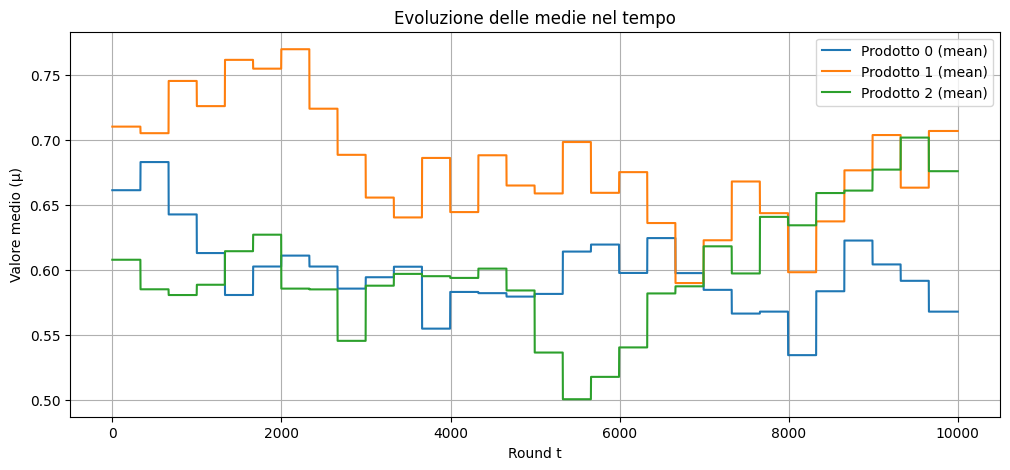

In [11]:
env = NonStationaryEnvironment(n_products=n_products, T=T, n_intervals=n_intervals, prices=prices)
env.generate_valuations_parameters()

# Plot delle medie
plt.figure(figsize=(12,5))

for p in range(n_products):
    plt.plot(env.means[:, p], label=f"Prodotto {p} (mean)")

plt.title("Evoluzione delle medie nel tempo")
plt.xlabel("Round t")
plt.ylabel("Valore medio (μ)")
plt.legend()
plt.grid(True)
plt.show()

# Plot delle deviazioni standard
#plt.figure(figsize=(12,5))

#for p in range(n_products):
#    plt.plot(env.stds[p], label=f"Prodotto {p} (std)")

#plt.title("Evoluzione delle deviazioni standard nel tempo")
#plt.xlabel("Round t")
#plt.ylabel("Deviazione standard (σ)")
#plt.legend()
#plt.grid(True)
#plt.show()


# Combinatorial-UCB Agent with Sliding Window

In [ ]:
class UCBSWAgent:

    def __init__(self, n_products, price_options, inventory, T, W,
                 confidence_bound=1.0, rho_penalty=1.0, use_pen_rho=True, selection_method='sampling', rng = None):

        self.rng = rng if rng else np.random.default_rng()

        #Number of rounds
        self.T = T

        #Window size
        self.W = W

        #Current round
        self.t = 0
        #Number of products
        self.n = n_products
        #Number of possible prices
        self.n_price = len(price_options)

        #Total initial inventory
        self.B = inventory

        self.remaining_inventory = inventory

        #Map product -> last price chosen for the product
        self.current_action = np.zeros(self.n, dtype=int)

        #Sliding window for the rewards of each price for each product and price
        self.cache_f = np.full((n_products, W, self.n_price), np.nan)    #3D Matrix [product, t in the window, price]

        #Sliding window for the purcase probabilities for each product and price
        self.cache_c = np.full((n_products, W, self.n_price), np.nan)    #3D Matrix [product, t in the window, price]

        self.rho = self.B / self.T

         # equality constraints: sum of arm probabilities = 1 for each product
        self.A_eq = np.zeros((self.n, self.n*self.n_price))
        for dim in range(self.n):
            self.A_eq[dim,dim*self.n_price:(dim+1)*self.n_price] = 1
        self.b_eq = np.ones(self.n)

        #Value that tells me if we have fulled the sliding window for the first time
        self.if_full = False

        #Current position in the sliding window
        self.current_window_index = 0

        #print(self.cache_f)
        #print(self.cache_c)
    

    #For each product select a price. Return the list of prices for each product
    def pull_arm(self):



        #No inventory left, return an empty action
        if self.remaining_inventory < self.n:
            self.current_action = {}
            return self.current_action

        #First n_price round, pull each product with the t price
        if self.t < self.n_price:
            #print("We are in the initial phase, exploring each arm uniformly")
            self.current_action = np.full(self.n, self.t, dtype=int)
            #print("Subset: ", price_subset)
            return self.current_action

        #large_value = 1e7
        small_value = 1e-7

        #Number of times price p for product x was picked in the last W rounds
        n_pulls_last_w = np.sum(~np.isnan(self.cache_f), axis=1)

        #Print cache_f for first product
        """for i in range(self.n_price):
            for j in range(self.n_price):
                print(f"Window {i}, Price option {j}, Rewards in the window: {self.cache_f[0,i,j]}")"""

        #Exploration term of the CB, we add a small value to avoid division by zero
        sigma = np.sqrt(2*np.log(self.W)/(n_pulls_last_w+small_value))
        f_ucbs = np.nanmean(self.cache_f, axis=1) + sigma
        c_lcbs = np.nanmean(self.cache_c, axis=1) - sigma

        """print("Ucb on the reward for every arm")
        for i in range(self.n):
            for j in range(self.n_price):
                print(f"Product {i}, Price option {j}, Expected reward: {f_ucbs[i,j]}")"""

        gamma = self.compute_opt(f_ucbs, c_lcbs)

        #Sample prices for each product based on the computed distribution gamma
        for product in range(self.n):
            #Index of the price
            self.current_action[product] = self.rng.choice(self.n_price, p=gamma[product])

        return self.current_action


    def update(self, f_t, c_t):
        
        #print("Current window index: ", self.current_window_index)
        
        for product in range(self.n):
            if self.if_full:
                #Set all the revenue to null
                self.cache_f[product, self.current_window_index] = np.nan
                self.cache_c[product, self.current_window_index] = np.nan

            #print("Price index: ", self.current_action[product])            
            self.cache_f[product, self.current_window_index, self.current_action[product]] = f_t[product]
            self.cache_c[product, self.current_window_index, self.current_action[product]] = c_t[product]
            self.B -= c_t[product]
        self.rho = self.B/(self.T-self.t)
        self.t += 1

        #We fulled the window for the first time
        if (self.current_window_index +1) == self.W and self.if_full == False:
            self.if_full = True
            
        self.current_window_index = (self.current_window_index + 1) % self.W
            

    def compute_opt(self, f_ucbs, c_lcbs):
    

        # Flatten W and C for LP
        c = -f_ucbs.flatten()

        # Inequality constraints (shared inventory)
        A_ub = [c_lcbs.flatten()]
        b_ub = [self.rho]

        #Coefficients for equality constraints
        A_eq = self.A_eq

        # Bounds for each variable (gamma_ki between 0 and 1)
        bounds = [(0, 1) for _ in range(self.n*self.n_price)]

        # Solve linear program
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=self.b_eq,
                                 bounds=bounds, method='highs')

            if res.success:
                gamma_flat = res.x
                # Reshape gamma back to (n_products, n_price_options)
                gamma = gamma_flat.reshape((self.n, self.n_price))

                # Ensure valid probability distribution for each product
                for product_idx in range(self.n):
                    gamma[product_idx, :] = np.maximum(gamma[product_idx, :], 0)
                    sum_gamma = np.sum(gamma[product_idx, :])
                    if sum_gamma > 0:
                         gamma[product_idx, :] /= sum_gamma
                    else:
                         # Fallback: uniform distribution for this product
                         gamma[product_idx, :] = np.ones(self.n_price) / self.n_price

                return gamma
            else:
                # Fallback: uniform distribution for all products
                return np.ones((self.n, self.n_price)) / self.n_price
        except Exception as e:
            print(f"LP Error: {e}")
            # Fallback: uniform distribution for all products
            return np.ones((self.n, self.n_price)) / self.n_price

Now we compare the performances of our learner with the baseline. The baseline knows the true expected reward of each arm

In [13]:
#Compute the revenue of the baseline strategy that knows the distribution of valuations
def baseline_revenue(env, B, T):
     
    K = len(env.prices)

    #Reward for every product at each timestep
    reward_history = np.full((T, env.n_products),0.0)

    optimal_gamma = optimal_policy(env, B, T)
    inventory = B

    for t in range(T):
        #print("Step ",t , " in the optimal policy")
        if inventory < env.n_products:
            print(f"Inventory deployed at step {t}")
            break
        arms = np.empty(env.n_products, dtype=int)
        for product in range(env.n_products):
            #For everyproduct sample a price (the index))
            arms[product] = np.random.choice(K, p = optimal_gamma[product])
       
        #Price selected for each product
        prices = env.prices[arms]

        #Reward for each product at time t: if valuation > price -> reward = price, else 0
        rewards = env.get_rewards(t, prices)

        #Inventory consumed
        inventory -= np.count_nonzero(rewards)


        reward_history[t] = rewards
    #Return the cumulative reward of each product overtime    
    return reward_history


#Compute the optimal policy knowing the true expected rewards and purchase probabilities
def optimal_policy(env, B, T):
    
    n = env.n_products
    K = len(env.prices)

    #Compute true expected reward  and demand probabilities for each product and price
    #expected_rewards = np.zeros((n, K))
    purchase_prob = np.zeros((T, n, K))

    for t in range(T):
         for i in range(n):
            for j in range(K):
                 #P(valuation > price) = 1 - CDF(price) for each product and for each timestep
                 purchase_prob[t,i,j] = 1 - norm.cdf(env.prices[j], loc=env.means[t,i], scale=env.stds[i])

    #Compute the avarage purchase probability over time for each product and price
    avg_purchase_prob = purchase_prob.mean(axis=0)

    #Compute the expected reward for each product and price
    expected_rewards = np.zeros((n, K))
    for i in range(n):
         expected_rewards[i,:] = env.prices * avg_purchase_prob[i,:]

    #Initialize the coefficient matrix for equality constraints
    A_eq = np.zeros((n, n*K))
    b_eq = np.ones(n)

    for dim in range(n):
        A_eq[dim,dim*K:(dim+1)*K] = 1

    c = -expected_rewards.flatten()
    A_ub = [avg_purchase_prob.flatten()]
    b_ub = [B/T]
    

    # Solve linear program
    try:
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq = b_eq,
                                bounds=(0,1))
        if res.success:
            gamma_flat = res.x
            # Reshape gamma back to (n_products, n_price_options)
            gamma = gamma_flat.reshape((n, K))

            # Ensure valid probability distribution for each product
            for product_idx in range(n):
                gamma[product_idx, :] = np.maximum(gamma[product_idx, :], 0)
                sum_gamma = np.sum(gamma[product_idx, :])
                if sum_gamma > 0:
                        gamma[product_idx, :] /= sum_gamma
                else:
                        # Fallback: uniform distribution for this product
                        gamma[product_idx, :] = np.ones(K) / n

            return gamma
        else:
            # Fallback: uniform distribution for all products
            return np.ones((n, K)) / K
    except Exception as e:
        print(f"LP Error: {e}")
        # Fallback: uniform distribution for all products
        return np.ones((n, K)) / K



In [14]:
#Initialize the environment
env = NonStationaryEnvironment(n_products=n_products, T=T, n_intervals=n_intervals, prices=prices)

#Initialize the agent
agent = UCBSWAgent(n_products=n_products, price_options=prices, inventory=B, T=T, W=W)


#total_reward = 0
reward_history = np.zeros((T,env.n_products))

#for t in tqdm(range(T)):
for t in range(T):
    
    #print("Step ", t)
    #Agent selects a price for each product
    arm = agent.pull_arm()
    if arm.size == 0:
        print("Not enough inventory left at time step", t, '\n')
        break

    price = env.prices[arm]

    #Vector of the rewards of the arm
    f_t = env.get_rewards(t, price)
    
    #Vector of the cost of the arm
    c_t = (f_t != 0).astype(int)
    reward_history[t] = f_t
    agent.update(f_t, c_t)

#Cumulative reward of each product over time
agent_cumulative_reward = reward_history.cumsum(axis=0)

#Reward history of the baseline
baseline_reward_history = baseline_revenue(env, B, T)
baseline_cumulative_reward = baseline_reward_history.cumsum(axis=0)

print("Agent cumulative reward\n")
print(agent_cumulative_reward)
print("Baseline cumulative reward\n")
print(baseline_cumulative_reward)
    

Agent cumulative reward

[[0.00000e+00 0.00000e+00 0.00000e+00]
 [2.50000e-01 2.50000e-01 2.50000e-01]
 [7.50000e-01 2.50000e-01 7.50000e-01]
 ...
 [2.11625e+03 5.80750e+02 2.32850e+03]
 [2.11625e+03 5.81000e+02 2.32850e+03]
 [2.11625e+03 5.81000e+02 2.32900e+03]]
Baseline cumulative reward

[[5.00000e-01 0.00000e+00 0.00000e+00]
 [1.00000e+00 0.00000e+00 0.00000e+00]
 [1.00000e+00 5.00000e-01 0.00000e+00]
 ...
 [3.33325e+03 5.22000e+02 1.75950e+03]
 [3.33375e+03 5.22000e+02 1.75950e+03]
 [3.33425e+03 5.22000e+02 1.75950e+03]]


# Plot of the cumulative rewards and regret

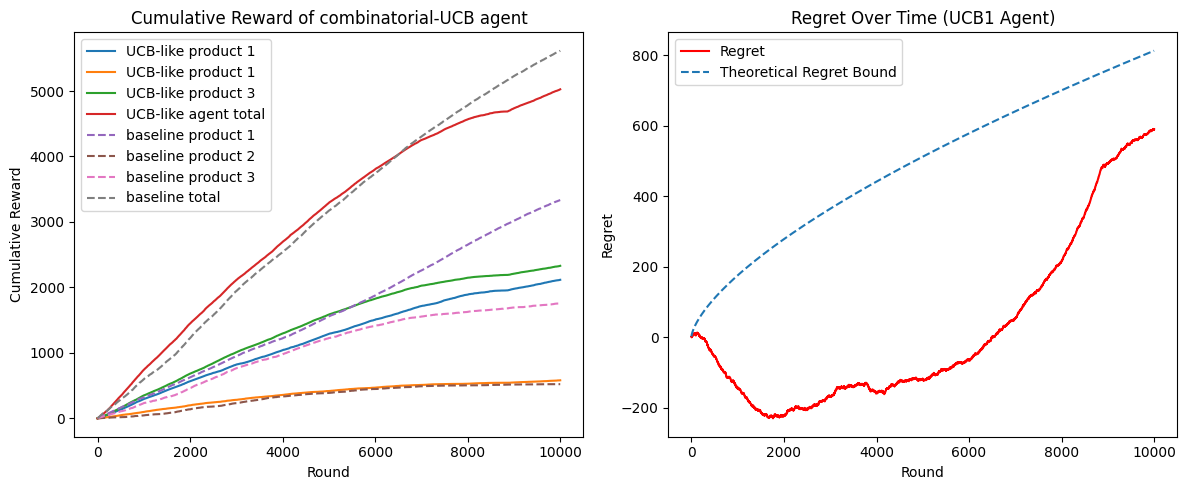

In [15]:
#Regret at each time step
regret = (baseline_cumulative_reward - agent_cumulative_reward).sum(axis=1)

theoretical_regret = [1.75*(t + 1)**(2/3) for t in range(len(regret))]  # Adjust scaling if needed

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(agent_cumulative_reward)
plt.plot(agent_cumulative_reward.sum(axis=1))
plt.plot(baseline_cumulative_reward, linestyle="--")
plt.plot(baseline_cumulative_reward.sum(axis=1), linestyle="--")
plt.xlabel("Round")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward of combinatorial-UCB agent")
plt.legend(["UCB-like product 1", "UCB-like product 1", "UCB-like product 3", "UCB-like agent total", "baseline product 1", "baseline product 2", "baseline product 3", "baseline total", ])

plt.subplot(1, 2, 2)
plt.plot(regret, label="Regret", color='red')
plt.plot(theoretical_regret, label="Theoretical Regret Bound", linestyle="--")
plt.xlabel("Round")
plt.ylabel("Regret")
plt.title("Regret Over Time (UCB1 Agent)")
plt.legend()

plt.tight_layout()
plt.show()
